# Learning to stabilize a linear system

For this example we demonstrate learning to stabilize a double integrator system using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="./figs/DPC_simple_method.png" width="600">  

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [2]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

# closed loop system definition
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the system operates in. 

In [3]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [7]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.0001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [8]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

epoch: 0  train_loss: 39.75463104248047
epoch: 1  train_loss: 39.77875900268555
epoch: 2  train_loss: 39.7634391784668
epoch: 3  train_loss: 39.77983856201172
epoch: 4  train_loss: 39.76179504394531
epoch: 5  train_loss: 39.751220703125
epoch: 6  train_loss: 39.756412506103516
epoch: 7  train_loss: 39.763240814208984
epoch: 8  train_loss: 39.75993728637695
epoch: 9  train_loss: 39.75104904174805
epoch: 10  train_loss: 39.74837112426758
epoch: 11  train_loss: 39.751792907714844
epoch: 12  train_loss: 39.754119873046875
epoch: 13  train_loss: 39.75190734863281
epoch: 14  train_loss: 39.747127532958984
epoch: 15  train_loss: 39.745540618896484
epoch: 16  train_loss: 39.74745178222656
epoch: 17  train_loss: 39.74856185913086
epoch: 18  train_loss: 39.747108459472656
epoch: 19  train_loss: 39.744205474853516
epoch: 20  train_loss: 39.7425422668457
epoch: 21  train_loss: 39.743412017822266
epoch: 22  train_loss: 39.744300842285156
epoch: 23  train_loss: 39.74336624145508
epoch: 24  train_los

epoch: 198  train_loss: 39.71435546875
epoch: 199  train_loss: 39.71432876586914
epoch: 200  train_loss: 39.71430206298828
epoch: 201  train_loss: 39.71427917480469
epoch: 202  train_loss: 39.71424865722656
epoch: 203  train_loss: 39.7142219543457
epoch: 204  train_loss: 39.714195251464844
epoch: 205  train_loss: 39.714168548583984
epoch: 206  train_loss: 39.71413803100586
epoch: 207  train_loss: 39.71411895751953
epoch: 208  train_loss: 39.714088439941406
epoch: 209  train_loss: 39.71406173706055
epoch: 210  train_loss: 39.71403503417969
epoch: 211  train_loss: 39.71400833129883
epoch: 212  train_loss: 39.71398162841797
epoch: 213  train_loss: 39.71396255493164
epoch: 214  train_loss: 39.713932037353516
epoch: 215  train_loss: 39.713905334472656
epoch: 216  train_loss: 39.71388244628906
epoch: 217  train_loss: 39.7138557434082
epoch: 218  train_loss: 39.71383285522461
epoch: 219  train_loss: 39.71380615234375
epoch: 220  train_loss: 39.71377944946289
epoch: 221  train_loss: 39.7137527

epoch: 395  train_loss: 39.711036682128906
epoch: 396  train_loss: 39.7110710144043
epoch: 397  train_loss: 39.710693359375
epoch: 398  train_loss: 39.71046829223633
epoch: 399  train_loss: 39.710670471191406


# Evaluate best model on a system rollout 


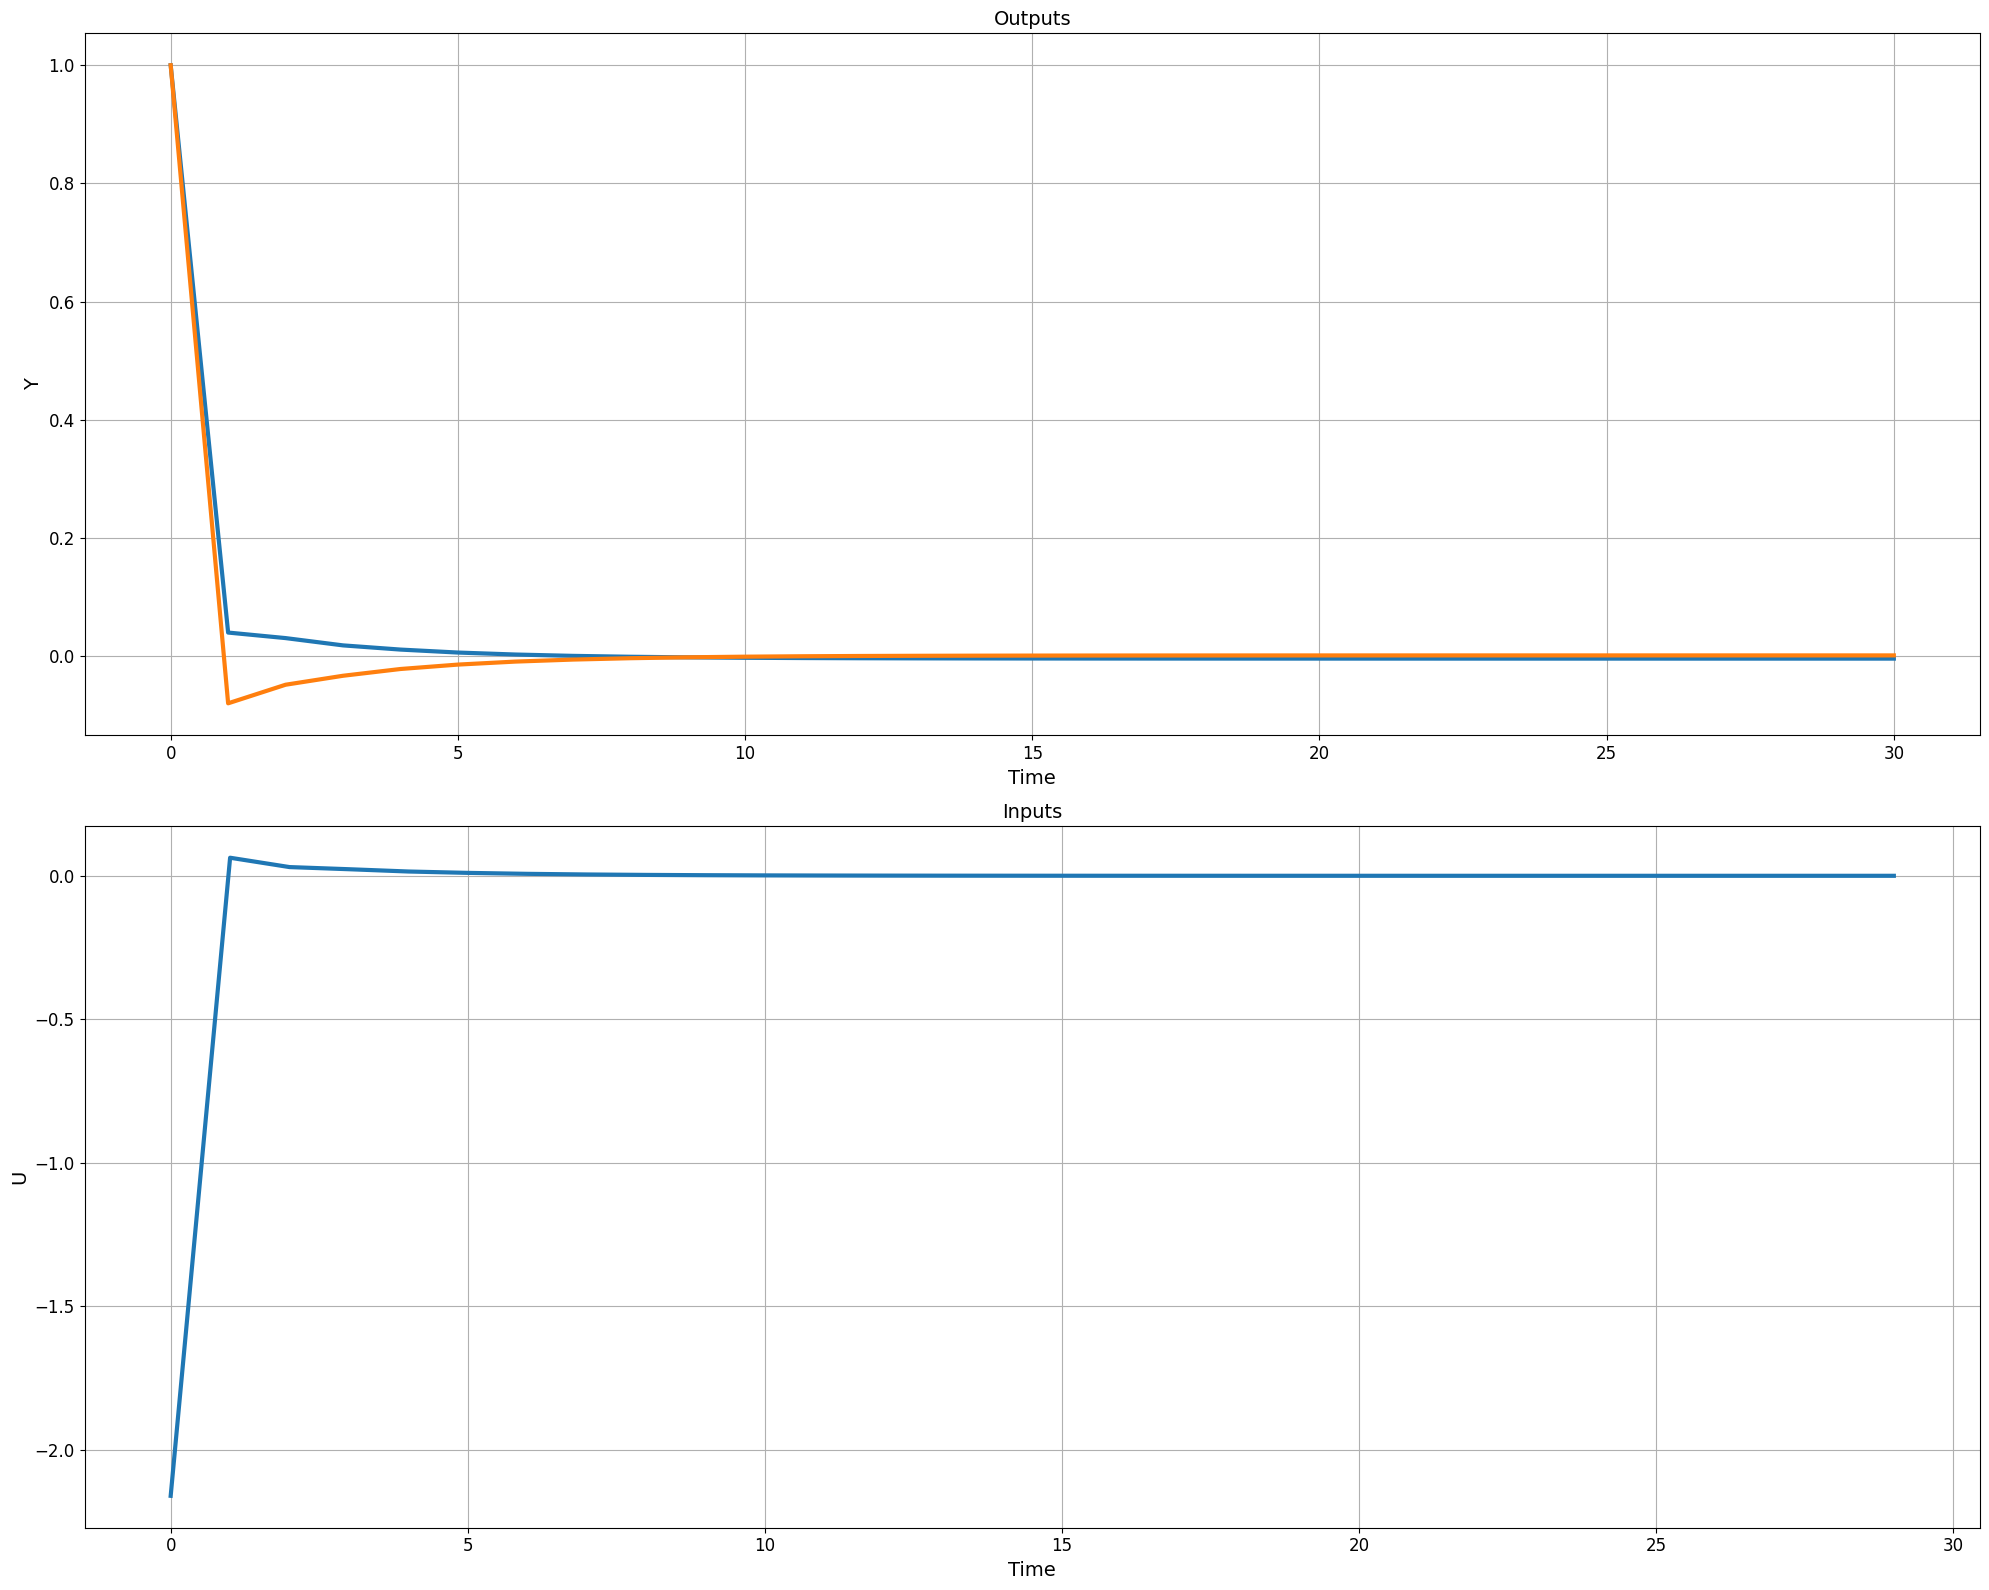

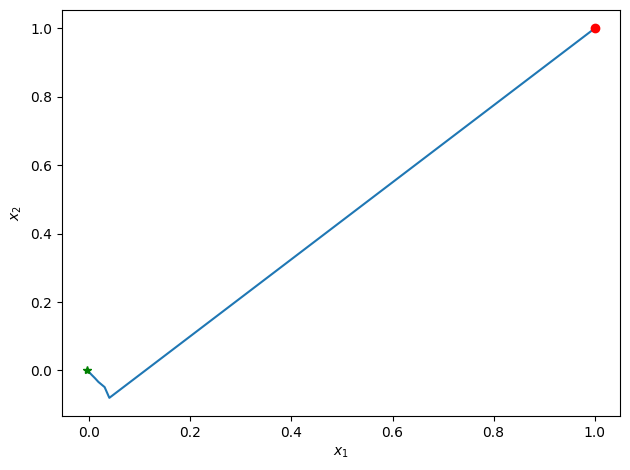

<Figure size 640x480 with 0 Axes>

In [9]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png')